# Как показать нейронке наличие тренда

In [38]:
import matplotlib.pyplot as plt

In [39]:
# Данные для построения графика
close = [10, 12, 11, 13, 12, 15, 13, 14, 12, 13, 11, 12, 10]
x = [1,2,3,4,5,6,7,8,9,10,11,12,13]

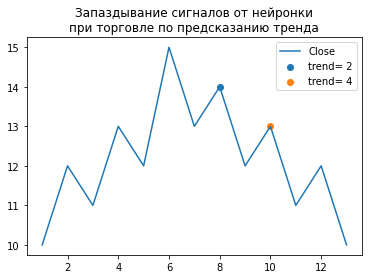

In [40]:
# Построение графика plot
plt.scatter(8, close[7], label='trend= 2')
plt.scatter(10, close[9], label='trend= 4')
plt.plot(x, close, label='Close')
plt.title('Запаздывание сигналов от нейронки\nпри торговле по предсказанию тренда')
plt.legend()
plt.show()

In [41]:
print('Рост = 1', '\nПлато = 0', '\nПадение = -1\n')

Рост = 1 
Плато = 0 
Падение = -1



In [42]:
def signal(x):
    if x > 0: signal = 1
    elif x < 0: signal = -1
    elif x == 0: signal = 0
    return signal

def trend(n, close = close):
    arr_trend = []
    for i in range(0, len(close)):
        if i < n: arr_trend.append(0) # пишем 0, если i меньше тренда
        else:
            x = close[i] - close[i - n] # находим разницу между close в начале и конце тренда
            arr_trend.append(signal(x))
    return arr_trend

In [43]:
# Попробуем определить тренд попарными разностями
print('Тренд по разностям (Close[i] - Close[i-1]): ', trend(1))

Тренд по разностям (Close[i] - Close[i-1]):  [0, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1]


In [44]:
# Определим тренд из 2х баров
print('Тренд по разностям (Close[i] - Close[i-2]): ', trend(2))

Тренд по разностям (Close[i] - Close[i-2]):  [0, 0, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1]


In [45]:
# Определим тренд из 3х и 4х баров
print('Тренд по разностям (Close[i] - Close[i-3]): ', trend(3))
print('Тренд по разностям (Close[i] - Close[i-4]): ', trend(4))
print('Вывод: Важно правильно подобрать тренд!')

Тренд по разностям (Close[i] - Close[i-3]):  [0, 0, 0, 1, 0, 1, 0, 1, -1, 0, -1, 0, -1]
Тренд по разностям (Close[i] - Close[i-4]):  [0, 0, 0, 0, 1, 1, 1, 1, 0, -1, -1, -1, -1]
Вывод: Важно правильно подобрать тренд!


# Проверка гипотезы тренда

In [46]:
import pandas as pd
import numpy as np
from numpy import array

import os

import warnings
warnings.filterwarnings("ignore")

In [47]:
trend = 14                # По скольки шагам в прошлое определяем тренд   
ticker = 'SBER_MIN60'     

## Подготовка данных

In [48]:
data = pd.read_csv('/content/SBER_MIN60.txt', sep="\t", header=None)
data.columns=['Date', 'Open', 'High', 'Low', 'Close']
data

,Date,Open,High,Low,Close
0,2000-01-05 11:00:00.000,1.15000,1.17000,1.0800,1.125
1,2000-01-05 12:00:00.000,1.13500,1.17300,1.1350,1.168
2,2000-01-05 13:00:00.000,1.16500,1.23999,1.1650,1.200
3,2000-01-05 14:00:00.000,1.20000,1.25500,1.1980,1.255
4,2000-01-05 15:00:00.000,1.23001,1.26488,1.2115,1.264
...,...,...,...,...,...
43128,2019-12-30 14:00:00.000,253.05000,255.25000,252.9700,255.210
43129,2019-12-30 15:00:00.000,255.20000,256.00000,254.8600,255.160
43130,2019-12-30 16:00:00.000,255.16000,255.94000,254.5300,255.620
43131,2019-12-30 17:00:00.000,255.62000,255.65000,254.5500,254.810


In [49]:
mask = (data['Date'] >= '2010-01-01 10:00:00.000') & (data['Date'] <= '2018-12-31 23:59:59.999') 
# Проверим, что период торговли выбран верно
data = data[mask][-595:]
data

,Date,Open,High,Low,Close
40270,2018-09-27 18:00:00.000,203.38,204.10,202.43,204.10
40271,2018-09-28 10:00:00.000,204.93,205.67,202.13,202.23
40272,2018-09-28 11:00:00.000,202.21,204.90,201.81,204.90
40273,2018-09-28 12:00:00.000,204.81,204.90,203.12,203.18
40274,2018-09-28 13:00:00.000,203.20,203.80,201.12,202.10
...,...,...,...,...,...
40860,2018-12-29 14:00:00.000,186.07,186.08,185.78,185.88
40861,2018-12-29 15:00:00.000,185.88,185.95,185.70,185.70
40862,2018-12-29 16:00:00.000,185.70,186.15,185.70,186.15
40863,2018-12-29 17:00:00.000,186.15,186.35,186.00,186.02


## Необходимые функции

In [50]:
def arr_preparing(data, trend):
  # Подготовим numpy-массивы для данных
  N = data.values.shape[0] 
  x = np.zeros((N, 1 + trend))  
  #y = np.zeros((N, 2)) # это для OHE
  y = np.zeros((N))

  # Заполняем данными (1 = рост, 0 = все остальное)
  for i in range(N):
      x[i, 0] = data.Close.values[i] # 0-й столбец - цены close
      for j in range(1, 1 + trend):
          x[i, j] = 1. if i >= j and x[i, 0] - x[i - j, 0] > 0 else 0. # столбцы 1 - 14 - знаки попарных разностей текущей цены и цены j часов назад. 
      if x[i, trend] > 0.5:  # OHE последнего столбца x[i, 14] (на самом деле это лишнее, надо было использовать бин кросс-энтропию)
          #y[i, 1] = 1 # это для OHE
          y[i] = 1
      else:
          #y[i, 0] = 1 # это для OHE
          y[i] = 0

  # удаляем число строк = trend(так как там не может быть попарных разностей)
  x = x[trend:]
  y = y[trend:]

  return x, y

x, y = arr_preparing(data[mask], trend = 5) 
x.shape, y.shape

((590, 6), (590,))

In [51]:
#def trading(model, xTest):
def trading(xTest, yTest):  
  returns = pd.DataFrame()
  statement = 0 #  {0:in_cash, 1:long, 2:short}
  stock = 0.   # Число акций
  cash = 1000000.   # Стартовая сумма капитала
  # -----------------------------------------

  for i in range(len(xTest)):   # Выбираю пример
    x = xTest[i]
    x = np.expand_dims(x, axis=0)
    signal = yTest[i]
    close = xTest[i][0]

    if statement == 0  and  signal == 1:
      statement = 1
      capital = cash//close * close + cash - cash//close * close
      inv_capital = cash//close * close
      line = pd.DataFrame({'statement':[0], 'signal':[signal], 'close':[close],'stock':[cash//close], 'deal_prise':[close],
                           'long':[close*0.9], 'short':[0], 'inv_capital':[inv_capital], 'cash':[cash - cash//close * close],
                           'capital':[capital], 'ret(i)':[0] })
      returns = returns.append(line, ignore_index=True)
      continue
  
    elif statement == 0  and  signal == 0:
      line = pd.DataFrame({'statement':[statement], 'signal':[signal], 'close':[close],'stock':[0],  'deal_prise':[0],
                           'long':[0], 'short':[0], 'inv_capital':[0], 'cash':[cash], 'capital':[cash], 'ret(i)':[0] })
      returns = returns.append(line, ignore_index=True)
      continue
      
    elif statement == 1  and  signal == 1:
      stock = returns.iloc[i-1][3]
      cash = returns.iloc[i-1][8]
      inv_capital = close*stock
      capital = close*stock+cash
      line = pd.DataFrame({'statement':[statement], 'signal':[signal], 'close':[close], 'stock':[stock], 'deal_prise':[returns.iloc[i-1][4]],
                           'long':[0], 'short':[0], 'inv_capital':[inv_capital], 'cash':[cash],  'capital':[capital], 'ret(i)':[0] })
      returns = returns.append(line, ignore_index=True)
      continue

    elif statement == 1  and  signal == 0:  ## выходим в кэш!
      statement = 0
      stock = returns.iloc[i-1][3]
      ret = (close - returns.iloc[i-1][4]) * stock
      capital = close * stock + returns.iloc[i-1][8]
      stock = 0
      inv_capital = close*stock
      cash = capital - inv_capital
      line = pd.DataFrame({'statement':[1], 'signal':[signal], 'close':[close], 'stock':[stock], 'deal_prise':[close],
                           'long':[0], 'short':[close*1.1], 'inv_capital':[inv_capital], 'cash':[cash], 'capital':[capital], 'ret(i)':[ret] })
      returns = returns.append(line, ignore_index=True)
      continue


  return returns


In [52]:
def plotting(returns):
  short = returns['short'].values
  short = short.astype(bool)
  long = returns['long'].values
  long = long.astype(bool)
  idx_long = np.where(long) 
  idx_short = np.where(short) 

  plt.figure(figsize=(18,5))

  plt.subplot(121)
  plt.plot(returns['close'], alpha=0.6)
  plt.plot(idx_long, returns['close'].values[[idx_long]], '^', c='g')
  plt.plot(idx_short, returns['close'].values[[idx_short]], 'v', c='r', fillstyle='none')
  plt.title('Trading signals for ' + ticker)

  plt.subplot(122)
  plt.plot(returns['capital'])
  plt.title('Прирост капитала: '+ ticker)
  plt.show()

## Подготовим numpy-массивы для данных

In [53]:
# Подготовим numpy-массивы для данных
x, y = arr_preparing(data, trend)
x[-10:], y[-10:], x.shape, y.shape

(array([[186.5 ,   0.  ,   1.  ,   1.  ,   0.  ,   1.  ,   1.  ,   1.  ,
           1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ],
        [186.4 ,   0.  ,   0.  ,   1.  ,   1.  ,   0.  ,   0.  ,   0.  ,
           1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ],
        [185.84,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
           0.  ,   0.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ],
        [185.7 ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
           0.  ,   0.  ,   0.  ,   1.  ,   1.  ,   1.  ,   1.  ],
        [186.08,   1.  ,   1.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
           0.  ,   0.  ,   0.  ,   0.  ,   1.  ,   1.  ,   1.  ],
        [185.88,   0.  ,   1.  ,   1.  ,   0.  ,   0.  ,   0.  ,   0.  ,
           0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   1.  ,   1.  ],
        [185.7 ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
           0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   1.  ],
        [186.15,   1.  ,   

## Торговля по тренду

In [54]:
%%time
# Расчет торговли по тренду:
returns = trading(x, y)
print(returns[-5:])

     statement  signal   close  ...        cash     capital   ret(i)
576          1     1.0  185.88  ...       68.88  1063860.12     0.00
577          1     1.0  185.70  ...       68.88  1062829.98     0.00
578          1     0.0  186.15  ...  1065405.33  1065405.33  5951.92
579          0     0.0  186.02  ...  1065405.33  1065405.33     0.00
580          0     0.0  186.34  ...  1065405.33  1065405.33     0.00

[5 rows x 11 columns]
CPU times: user 2.14 s, sys: 0 ns, total: 2.14 s
Wall time: 2.15 s


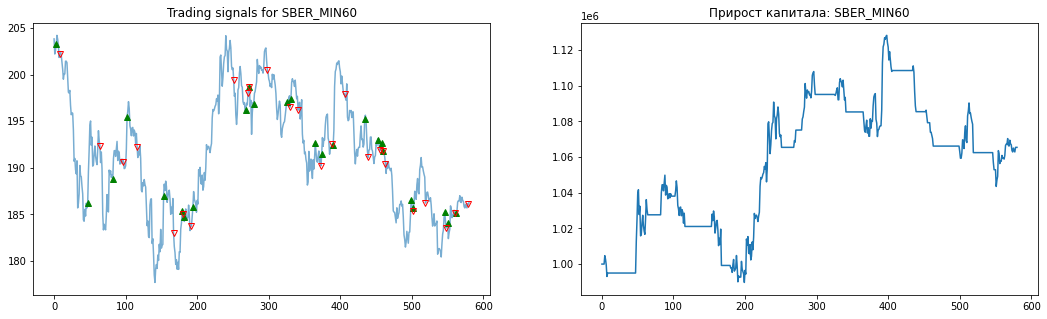

In [55]:
plotting(returns)

# Иллюстрация того, что тренд не постоянен

1144.4646 340.5608


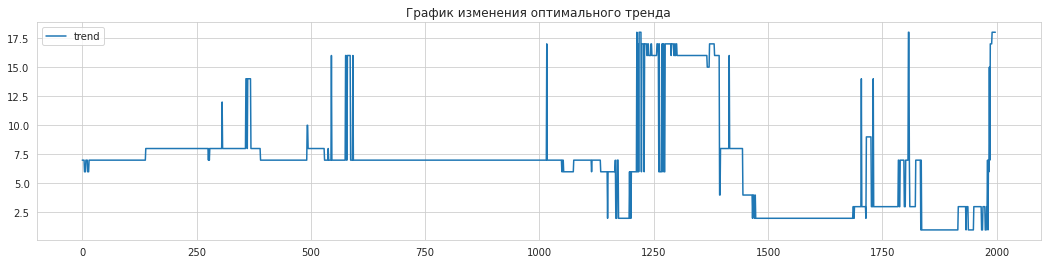

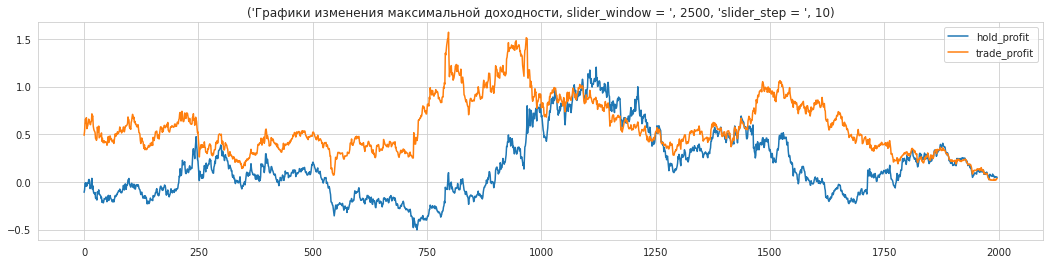

In [ ]:
# строим график
#best_trend.set_index(['date_start'],inplace=True)
plt.figure(figsize=(18,4))
best_trend['trend'].plot()
plt.legend()
plt.title('График изменения оптимального тренда')

print(best_trend['trade_profit'].sum(), best_trend['hold_profit'].sum())


plt.figure(figsize=(18,4))
best_trend['hold_profit'].plot()
best_trend['trade_profit'].plot()
tit = 'Графики изменения максимальной доходности, slider_window = ', slider_window, 'slider_step = ', slider_step
plt.title(tit)
plt.legend()

#best_trend['trade_profit'].sum(), best_trend['hold_profit'].sum()